In [7]:
#from Tools import *
from photoObject import *
import numpy as np
import seaborn as sns
import pandas as pd
from BayesianInference import *
from random import Random
import random
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous
from astropy.io import ascii
import emcee
import pathos.multiprocessing as multiproc
from multiprocessing import Pool
import corner
from IPython.display import display, Math



In [8]:
Catalog=ascii.read('../../A-Catalogs/Binospec-Candels.cat')
Photometry = [PhotoObject(c) for c in Catalog]


### Lets make mock Muv and Redshifts

- First assume Muv is Gaussianly distributed

In [25]:

def Muv_mock(mean,std_dev):
    #values = np.random.normal(mean, std_dev, 1000)
    values = np.random.normal(-20,1, 1000)
    mask= (values<-18.5) & (values>-23)
    return values[mask]

Muv=Muv_mock(-20,1)      #np.array([-19 for i in range(0,1000)])#Muv_mock(-20,1)
BInf=BayesInf()
BInf.Muv=Muv

In [26]:
%load_ext autoreload
%autoreload

mockParamsA=[0.15,0.6]
mockParamsW=[10,50]

ew,prob,A,W=BInf.GenerateMockData(mockParamsA,mockParamsW)
intrinsicEW=[RandomSampler(a,w) for a,w in zip(A,W)]
BInf.EW=intrinsicEW
Noise=5
EW_obs=BInf.RandomDrawEW(noise=Noise)
BInf.EW_obs=np.array(EW_obs)
BInf.noise=Noise
BInf.dEW=np.array([Noise for i in range(len(intrinsicEW))])
dEW=BInf.dEW
Detection_type=BInf.Classify(SNcut=-100)
#wtab=BInf.GenerateWtab()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


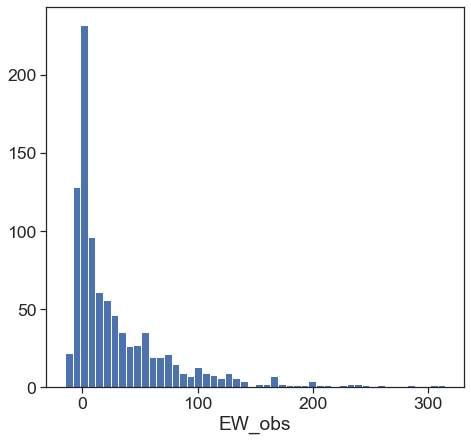

In [27]:
plt.hist(EW_obs,bins=50)
plt.xlabel('EW_obs')
plt.show()

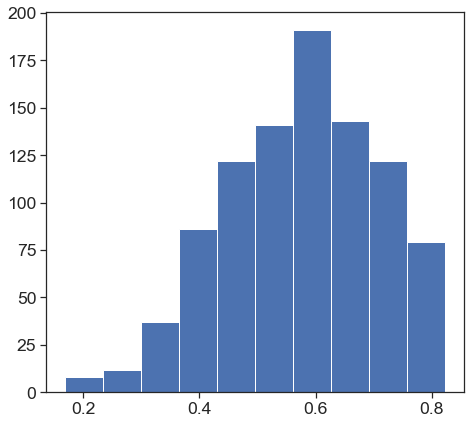

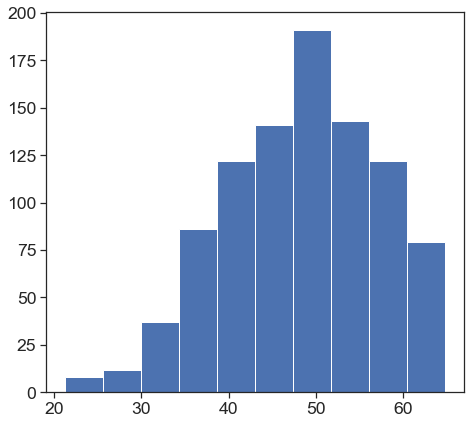

In [28]:
#mockParamsA=[0.2,0.6]
#mockParamsW=[20,50]

ew,prob,A,W=BInf.GenerateMockData(mockParamsA,mockParamsW)

plt.hist(A)
plt.show()
plt.hist(W)
plt.show()

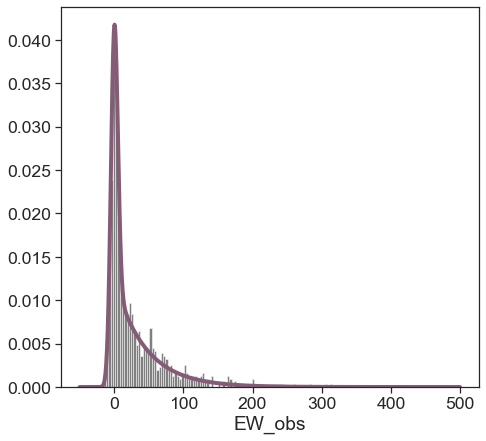

In [29]:
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
def Likelihood_TEST(ew,dEW,A,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    dEW_2 = dEW**2.
    p1 = (1. - A) * np.exp(-0.5 * ew**2./dEW_2) / np.sqrt(2.*np.pi) / dEW
    X  = (dEW_2/Wo - ew) / np.sqrt(2.) / dEW
    p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

ew=np.linspace(-50.,500,1001)    
dew=np.full(len(ew),Noise)

cmap = ListedColormap(Antique_3.mpl_colors)
sns.set_theme(style="ticks",font_scale=1.6)
plt.rcParams["figure.figsize"] = (7.5,7.)
fig, axs = plt.subplots()

y=Likelihood_TEST(ew,dew,0.55,45)
axs.plot(ew,y,lw=4,color=cmap(0.1),label=r"M$_\mathrm{UV}$ = -18.9, $\mathrm{\beta}$ = -2")
plt.hist(EW_obs,bins=100,density=True,alpha=0.5,color='black')
plt.xlabel('EW_obs')
plt.show()

In [30]:
def Likelihood(ew,dEW,A,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    if Wo<0:
        A=0

    dEW_2 = dEW**2.
    p1 = (1. - A) * np.exp(-0.5 * ew**2./dEW_2) / np.sqrt(2.*np.pi) / dEW
    X  = (dEW_2/Wo - ew) / np.sqrt(2.) / dEW
    p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

def ParameterModel(physParams,mathParams):
    """
    ParameterModel: Given the physical parameters and the mathematical parameters, it returns the parameter of the model
    
    Input:
    - physParams: Physical parameters (Muv)
    - mathParams: Mathematical parameters (Constants of the model A and Wo)
    Output:
    - Parameter: Parameter of the model A or Wo
    """
    Muv=physParams
    cMuv,cte= mathParams[0],mathParams[1]
    Parameter   =   ((Muv+20)*cMuv)  +   cte 
    return Parameter

def Posterior(ew,dew,physParams,mathParamsA,mathParamsW):
    """
    

    """
    A=ParameterModel(physParams,mathParamsA)
    Wo=ParameterModel(physParams,mathParamsW)
    #probLike=self.Likelihood(ew,A,Wo)
    probLike=[]
    for i in range(0,len(Detection_type)):
        #if Detection_type[i]=="LAE":
        p   =   Likelihood(ew[i],dew[i],A[i],Wo[i])
        #if Detection_type[i]=="nonLAE":
        #    p   =   self.LikNoDet(self.wtab,dew[i],A[i],Wo[i])
        
        if np.isnan(p)==True:
            continue

        probLike.append(p)
        
    return np.array(probLike)

def log_prior(theta,physParams=Muv):
    # I can put priors here or in the equation in the BInf object 
    Auv,Ac,Wuv,Wc= theta
    A =   ParameterModel(physParams,[Auv,Ac])
    W =   ParameterModel(physParams,[Wuv,Wc])
    #print(A,W)
    if (A >= 0.).all() and (A <=1.0).all() and (W > -50.).all():# and (W < 500.).all():
        return 0.0 

    return -np.inf

def log_likelihood(theta,y,yerr,physParams=Muv):
    Auv,Ac,Wuv,Wc = theta
    model = Posterior(y,yerr,physParams,[Auv,Ac],[Wuv,Wc]) # Does thus have to be exp, so it gets outside the logaritm?

    return np.sum(np.log(model))


def log_probability(theta, y, yerr):
    DrawnphysParams=Muv
    
    lp = log_prior(theta,physParams=DrawnphysParams)
    if not np.isfinite(lp):
        return -np.inf
    
    lL=log_likelihood(theta, y, yerr,physParams=DrawnphysParams)
    #print(lL)
    if np.isnan(lL)==True:
        return -np.inf
    else:
        return lp + lL

In [61]:
steps=1000
nwalkers=10

inValuesA=[0.,0.5]
inValuesW=[0,50]

inValues=inValuesA+inValuesW

pos = inValues+ [0.1,0.1,3,10] * np.random.randn(nwalkers,len(inValues) )
nwalkers, ndim = np.shape(pos)

#mp_pool = multiproc.ProcessPool(nodes=8)
#with mp_pool as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(EW_obs , dEW)
)
sampler.run_mcmc(pos, steps, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 17/1000 [00:02<02:08,  7.64it/s]<ipython-input-30-6778dc8ec0a5>:16: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-30-6778dc8ec0a5>:16: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100%|██████████| 1000/1000 [02:03<00:00,  8.09it/s]


State([[ 0.13249078  0.62436608  9.64845012 52.22083025]
 [ 0.12592131  0.62984827  4.46222092 49.75669321]
 [ 0.13949997  0.61948025 13.09528131 51.70923904]
 [ 0.10932132  0.62450172  8.3419056  49.65283328]
 [ 0.13474795  0.64314246  7.96723561 50.28866896]
 [ 0.11342691  0.62423106 12.40720174 53.03239368]
 [ 0.12357785  0.63690621 11.37488947 49.95345166]
 [ 0.10659153  0.63728191 10.59541366 48.7101491 ]
 [ 0.11675267  0.61354827 13.85106024 53.69350919]
 [ 0.12542441  0.6215582   8.83583887 49.54781602]], log_prob=[-4350.85689439 -4352.05337407 -4353.14305291 -4350.78601552
 -4351.28427454 -4351.73263324 -4351.70943945 -4351.88742071
 -4352.87127504 -4350.64476206], blobs=None, random_state=('MT19937', array([2482747062, 1633148542, 1547989221, 4164649931,    8984767,
       3018200764,   86689768, 2589506222, 1728656972, 1389994556,
        153388481,  572159446,  890253173, 1280604170,     773601,
       1083739804,   87532594,  571528199, 2323273104, 2234381398,
        48881

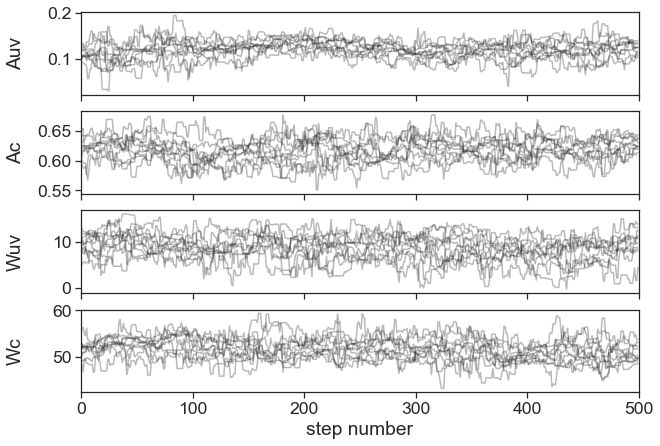

In [62]:

dis=500
labels = ["Auv","Ac","Wuv","Wc"]
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=dis)
logProb=sampler.get_log_prob(discard=dis)
maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
samples=np.array([s[maskWalkers] for s in samples])
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

(5000, 4)


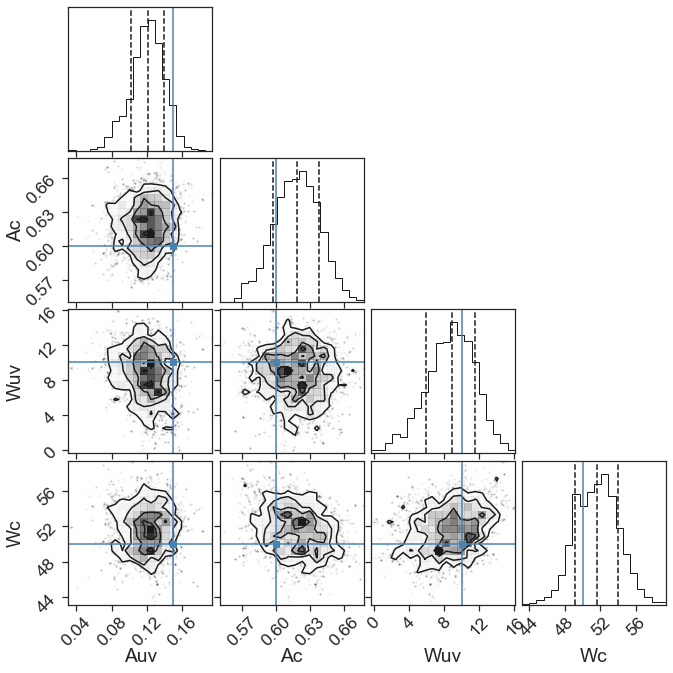

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [63]:

ndim=len(labels)
samples = sampler.get_chain(discard=dis)
samples=np.array([s[maskWalkers] for s in samples])
samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
print(np.shape(samples))


fig = corner.corner(
    samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
)
plt.show()

results=[]
r16,r84=[],[]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    results.append(mcmc[1])
    r16.append(mcmc[0])
    r84.append(mcmc[2])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


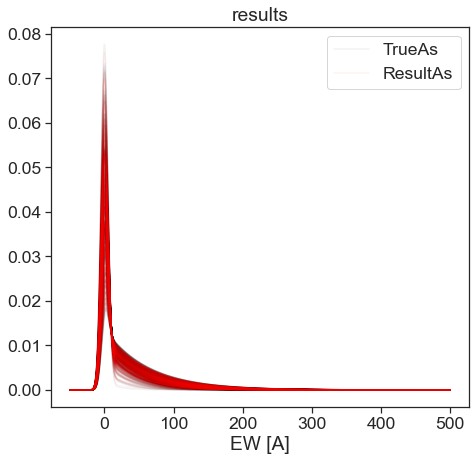

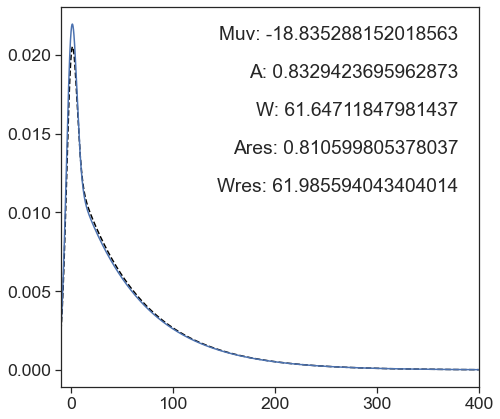

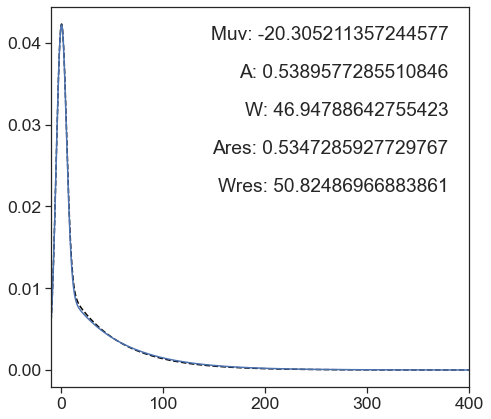

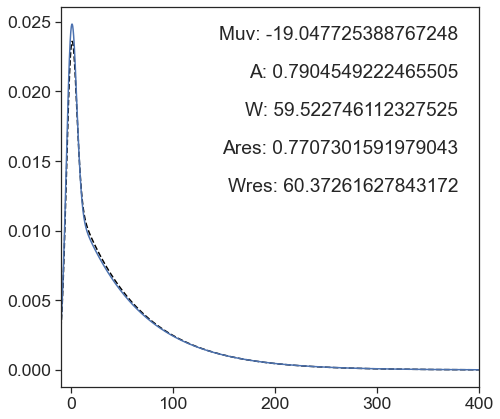

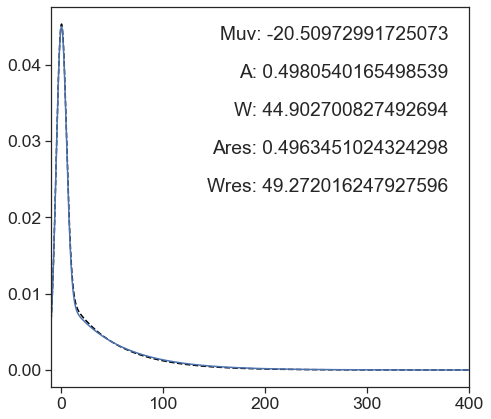

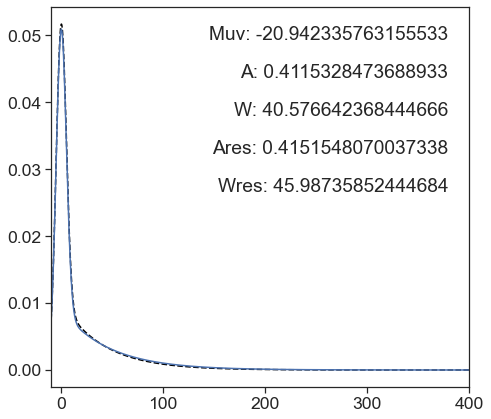

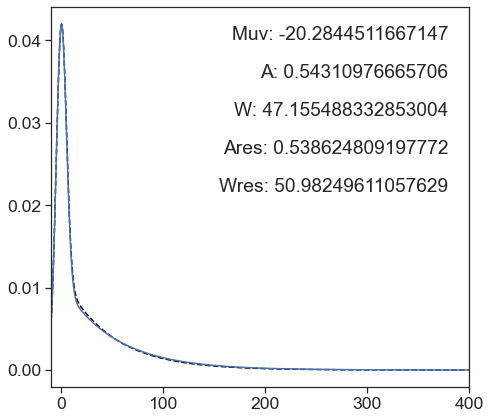

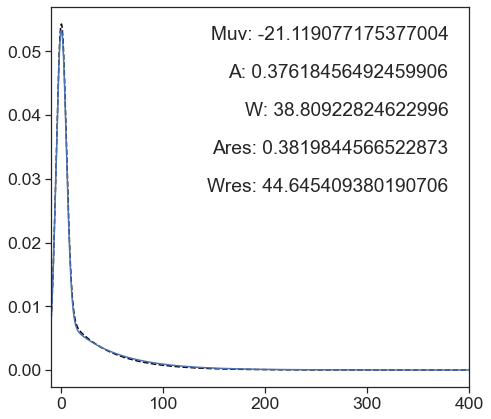

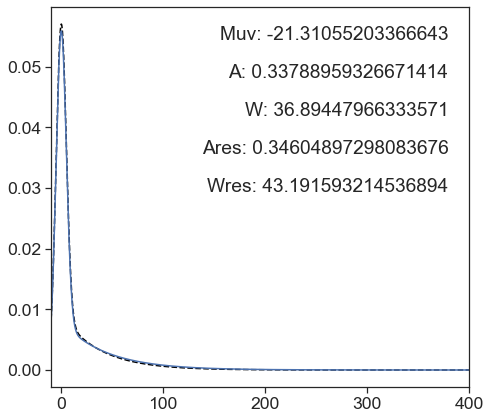

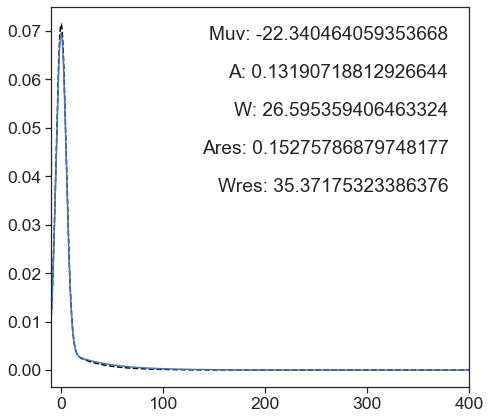

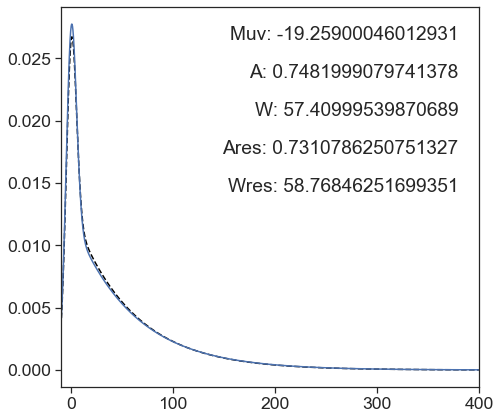

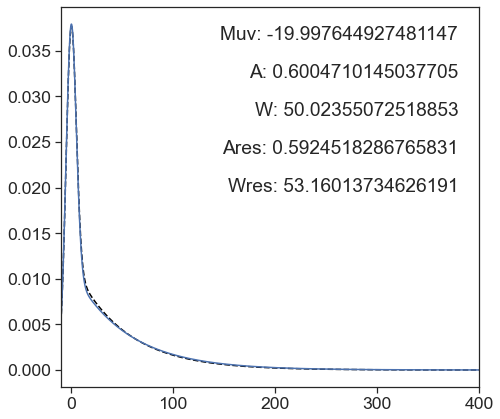

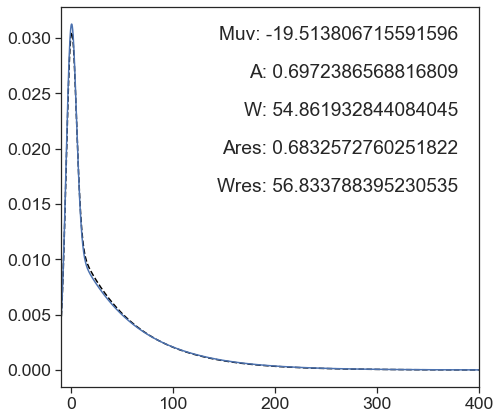

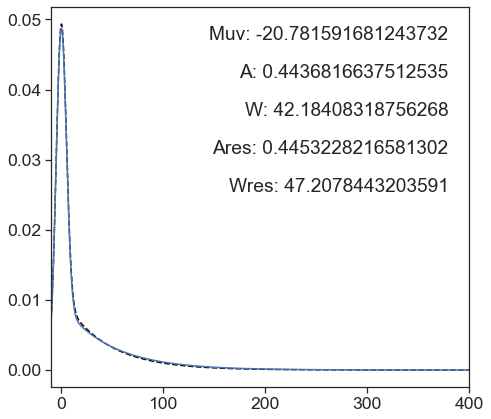

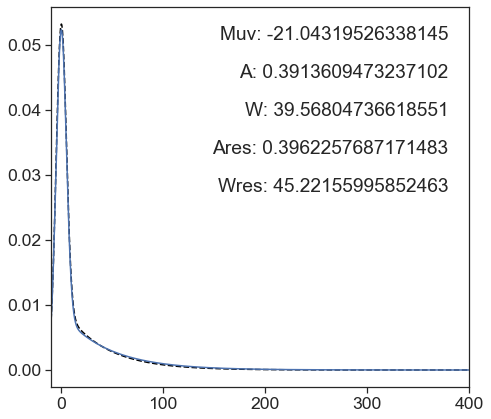

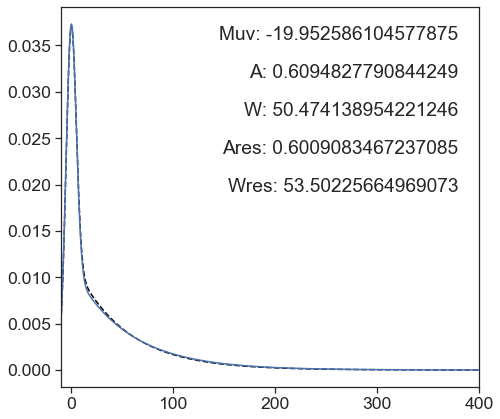

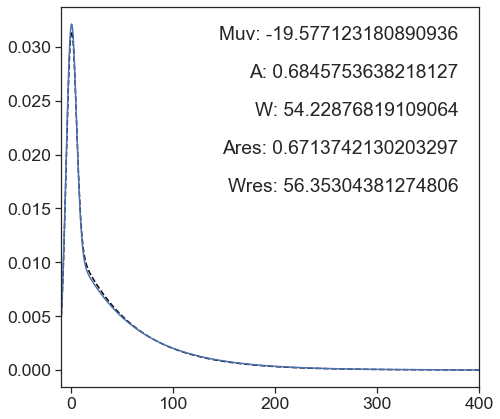

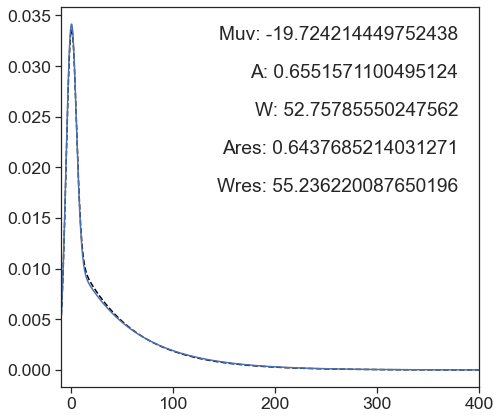

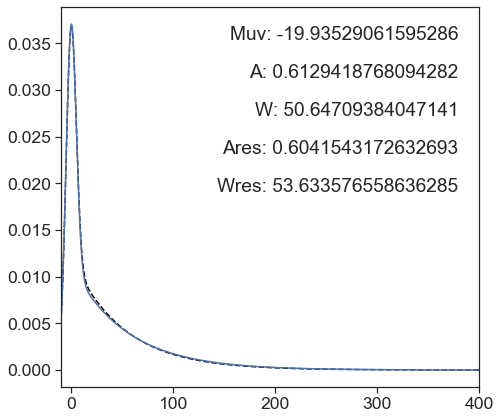

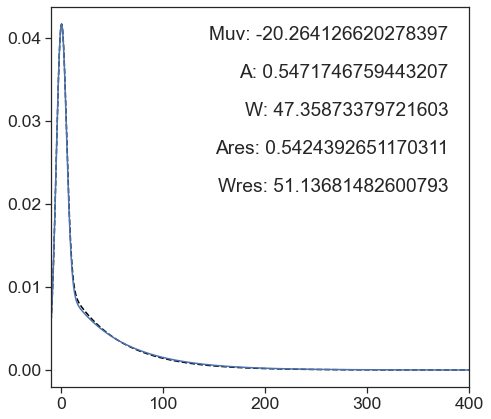

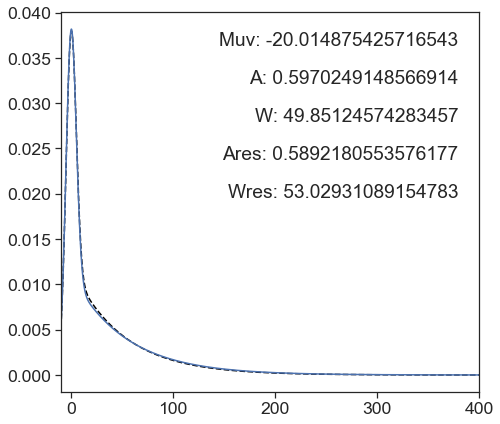

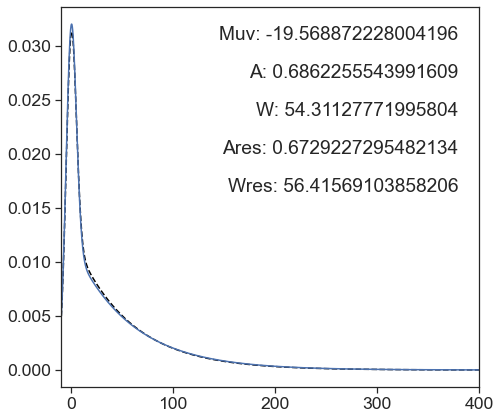

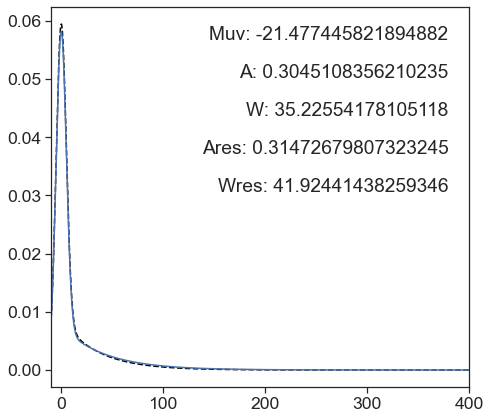

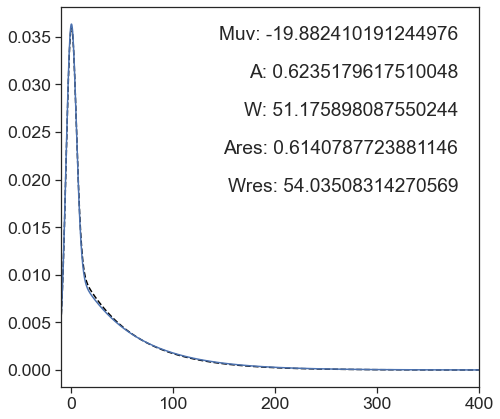

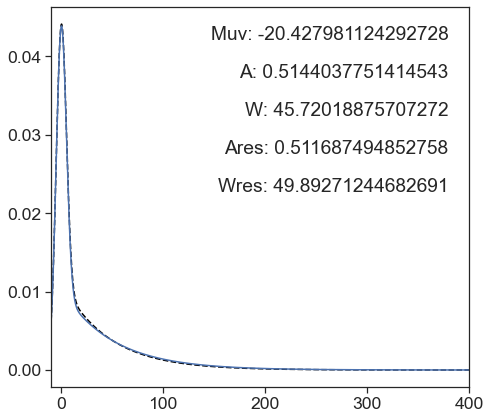

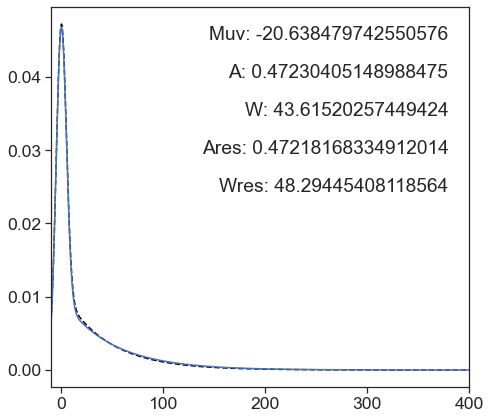

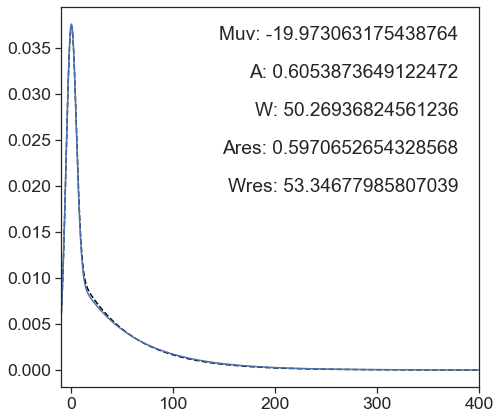

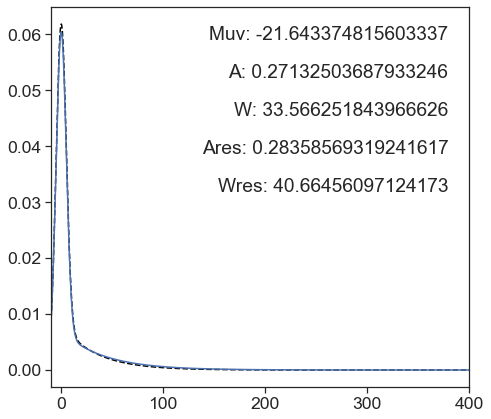

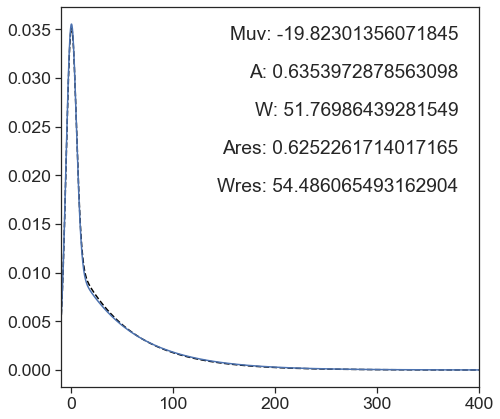

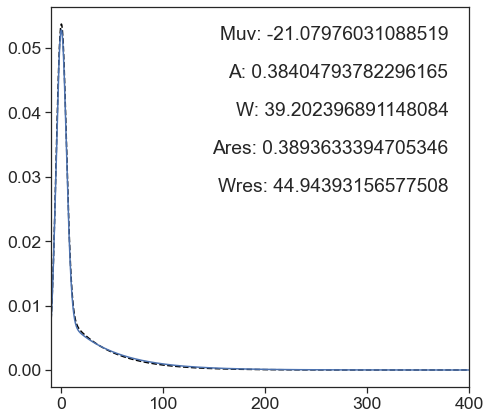

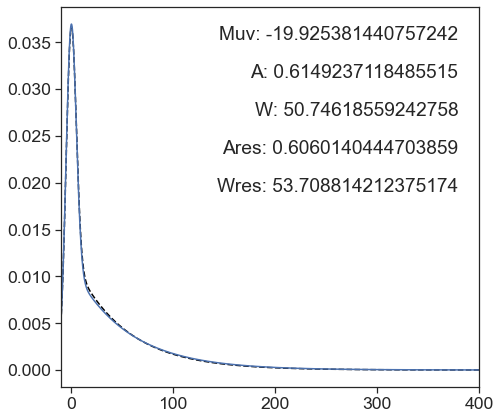

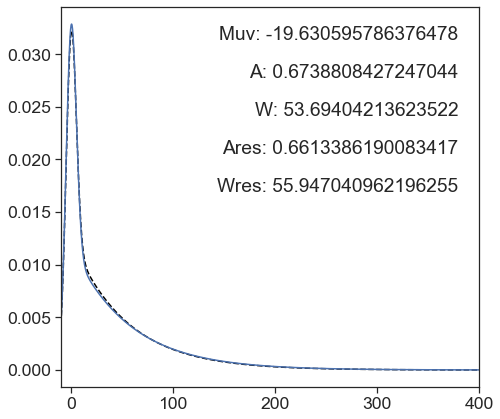

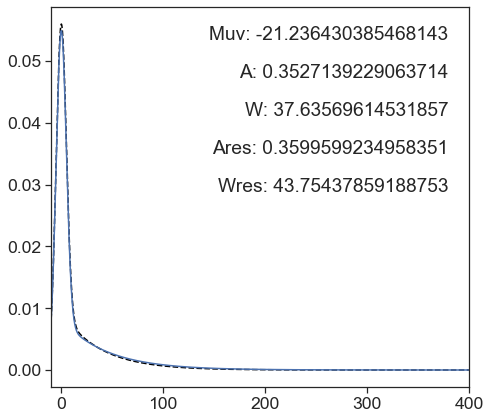

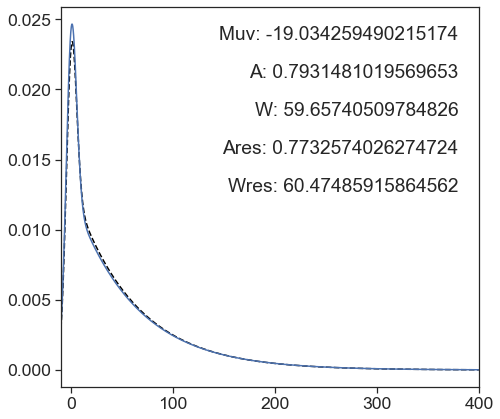

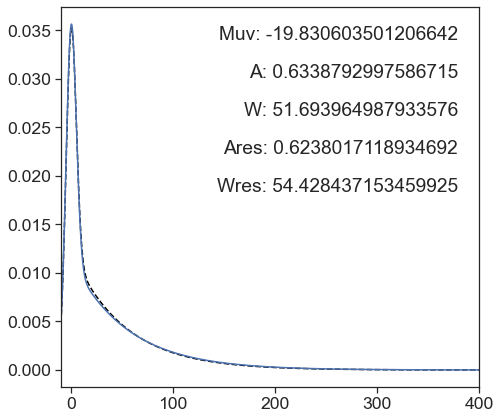

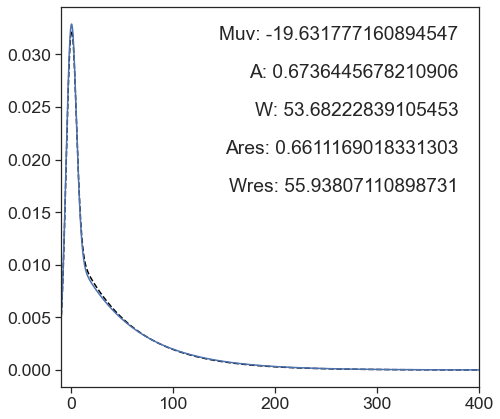

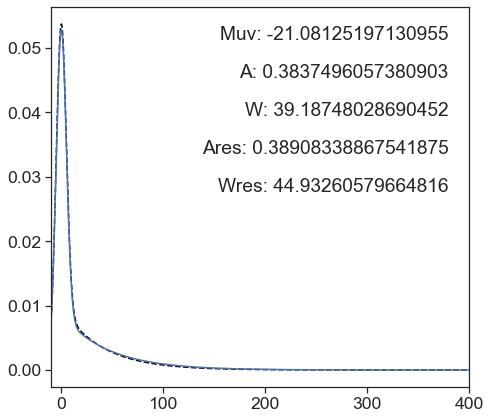

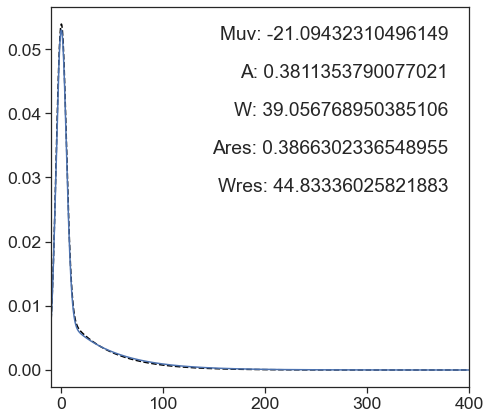

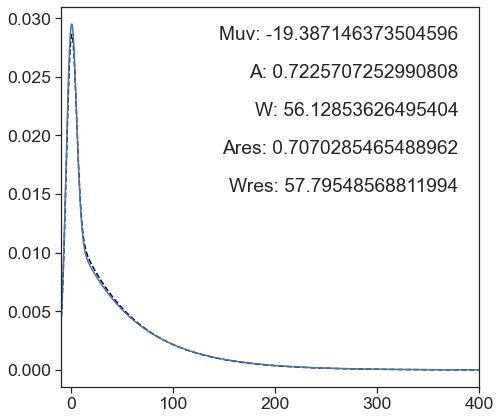

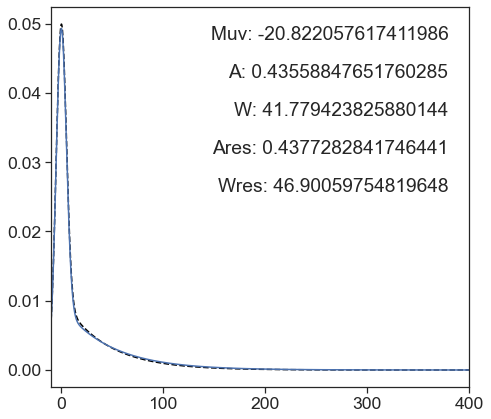

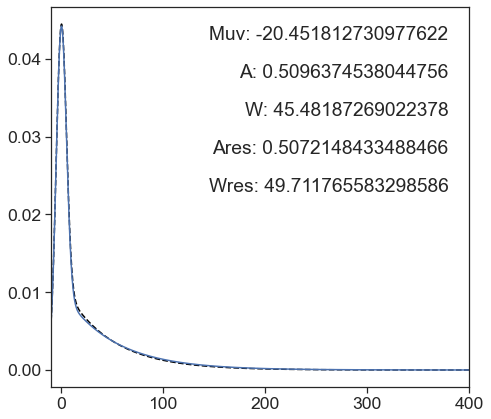

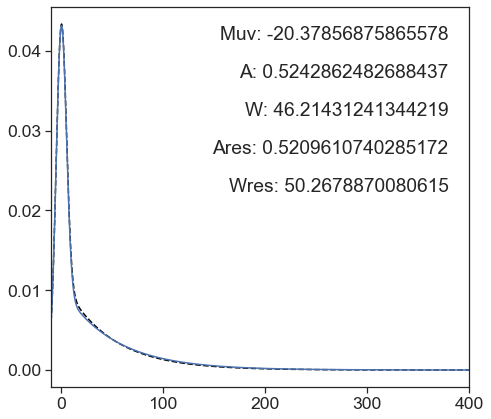

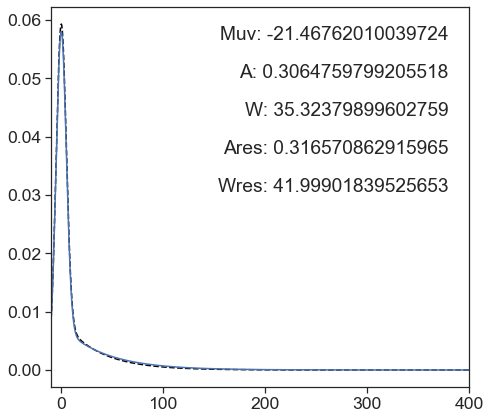

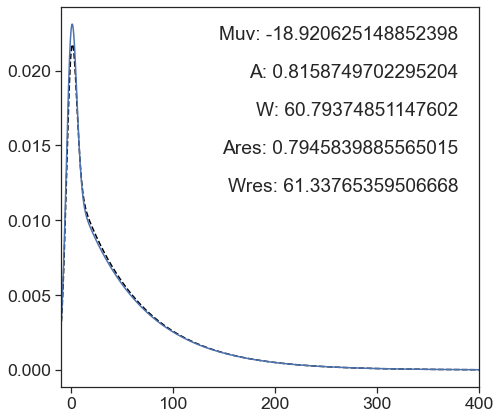

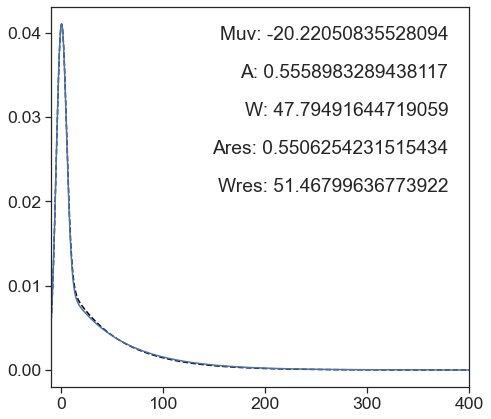

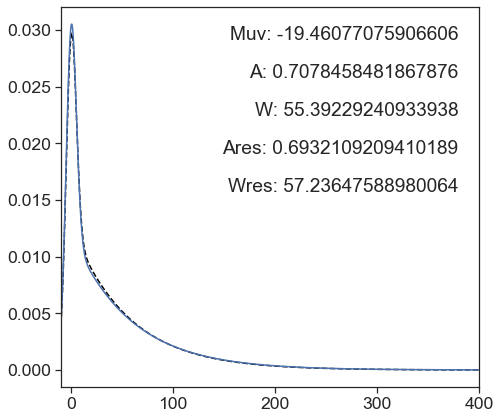

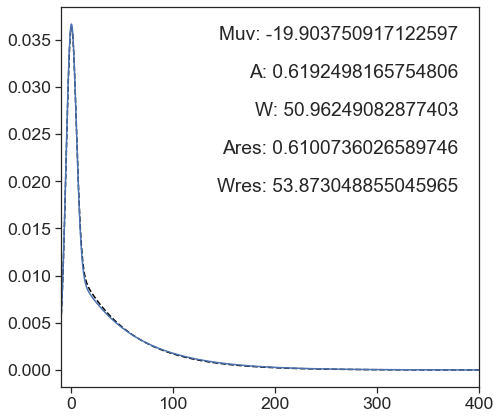

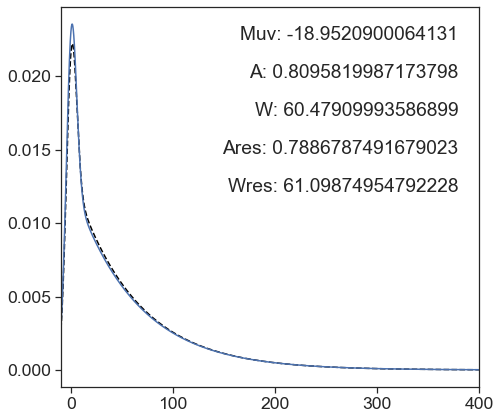

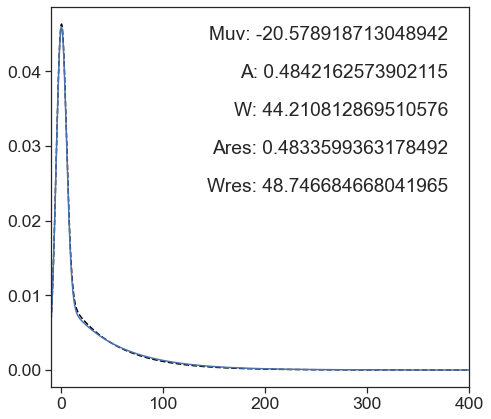

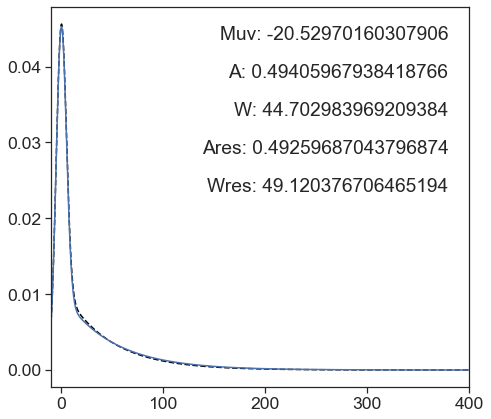

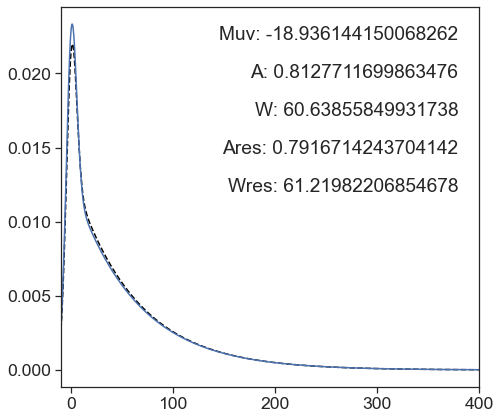

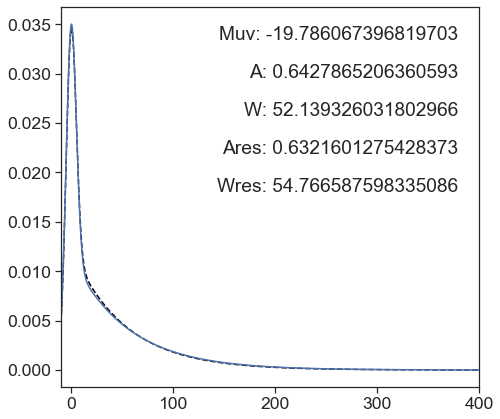

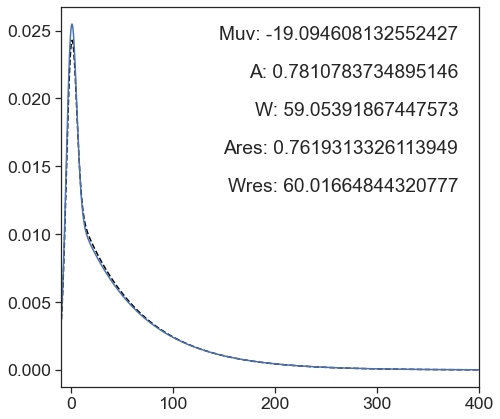

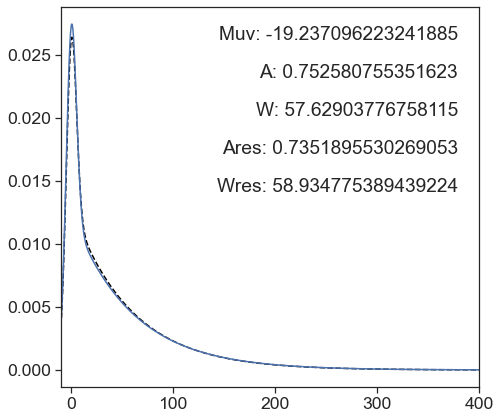

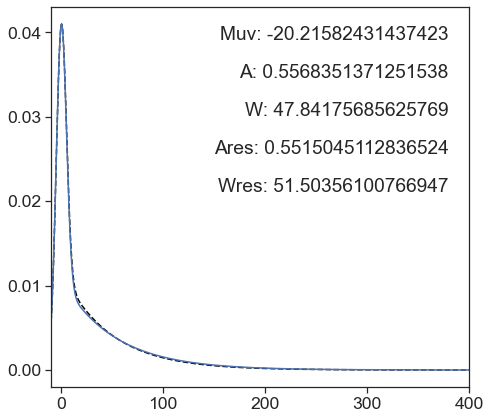

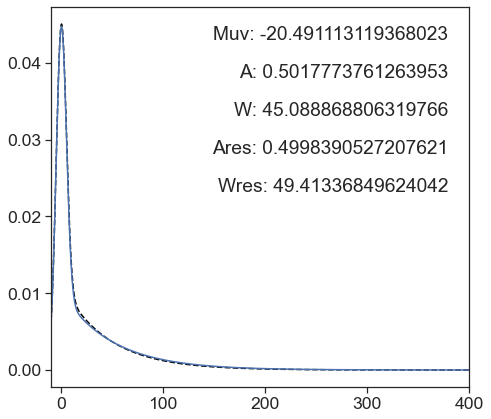

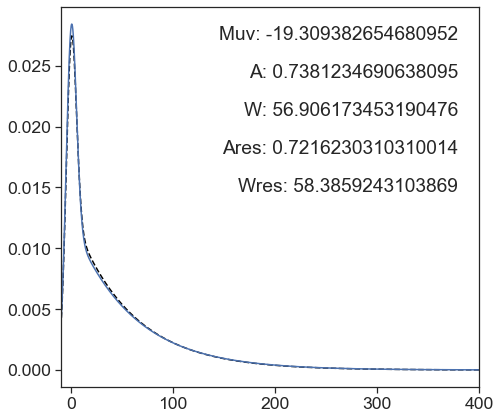

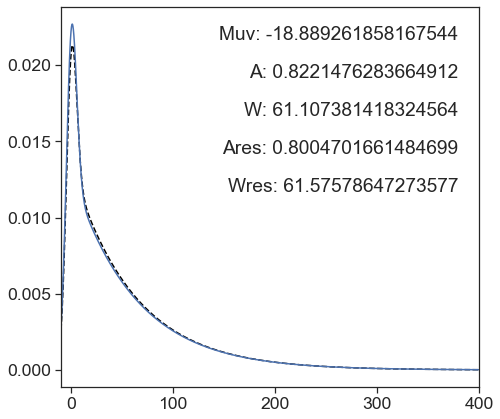

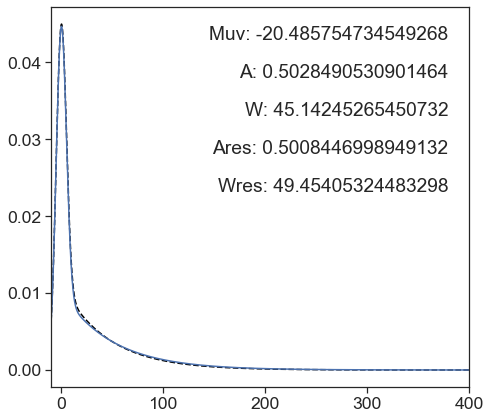

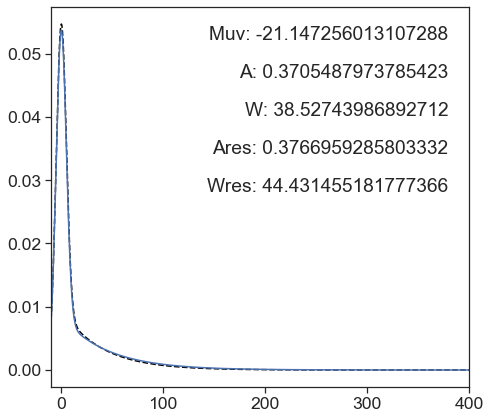

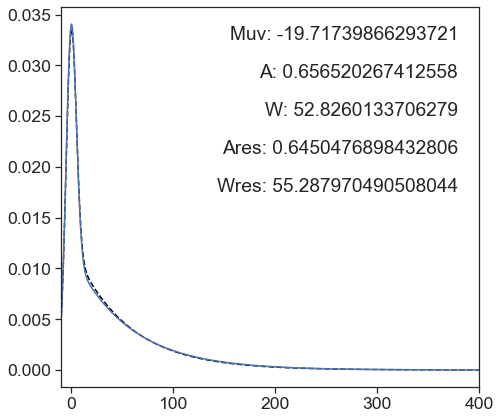

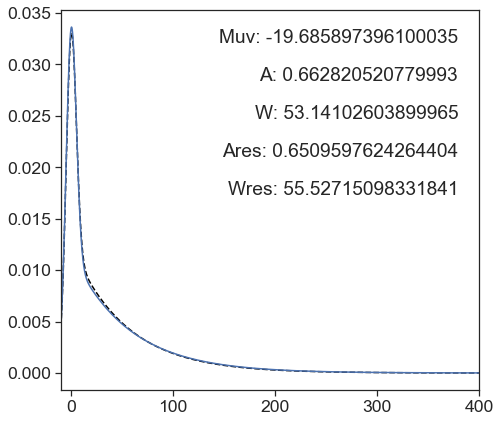

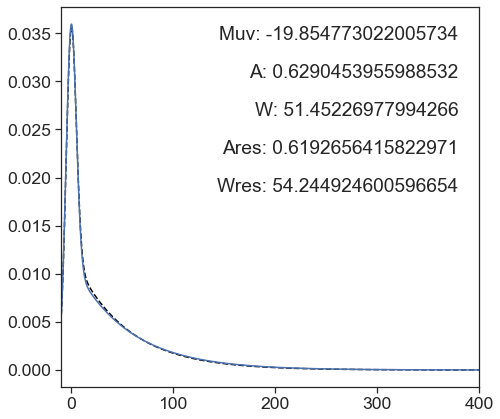

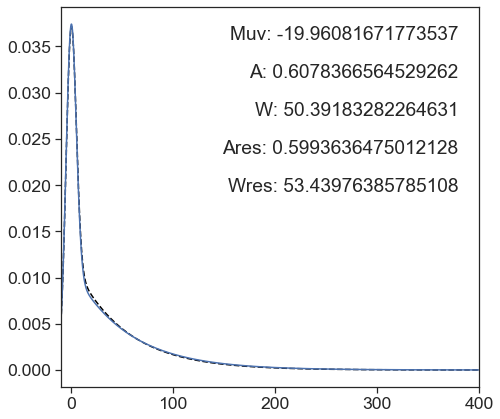

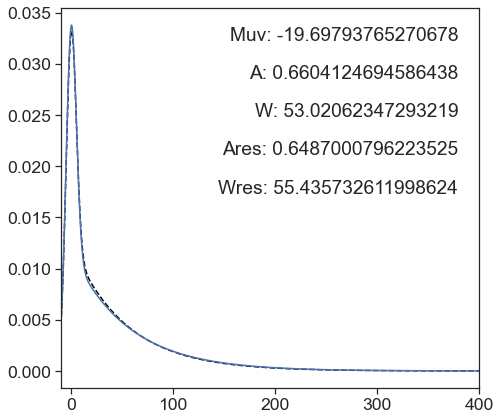

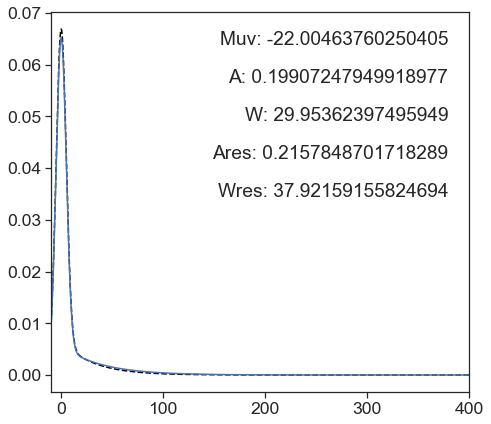

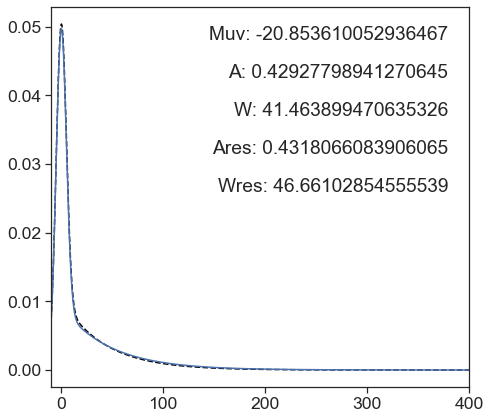

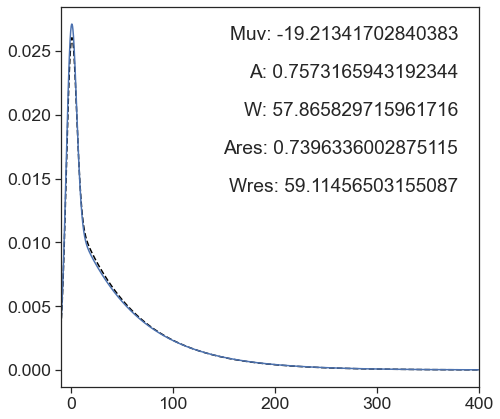

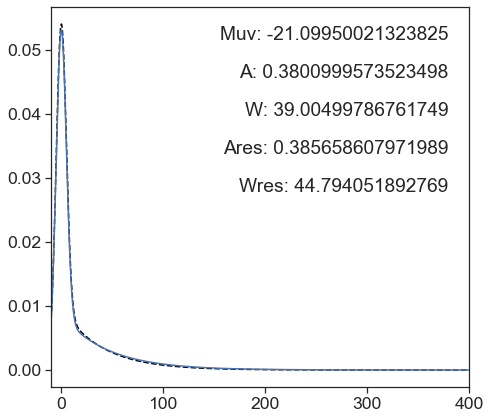

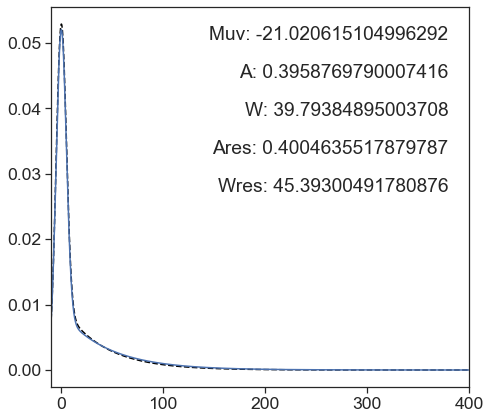

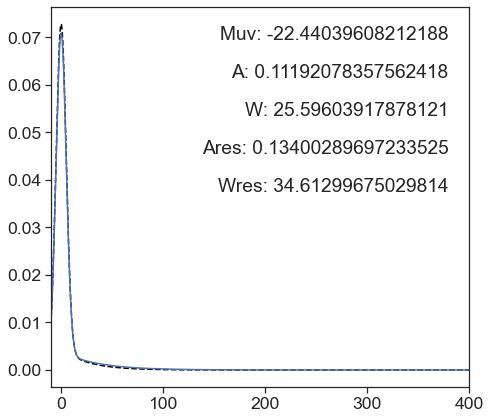

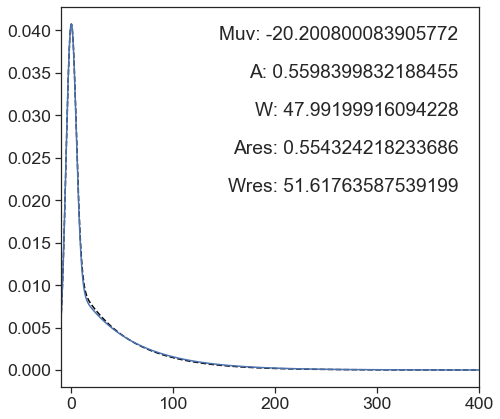

KeyboardInterrupt: 

In [36]:
%load_ext autoreload
%autoreload

mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x,probSets1,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
for prob in probSets1[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.05,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)




x,probSets2,Asr,Wsr=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
for prob in probSets2[:]:
    plt.plot(x,prob,color="red",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.plot(x,prob,color="red",alpha=0.05,label="ResultAs")
plt.legend()
plt.show()


import imageio
from PIL import Image
images = []

# Loop through the probSets1 and probSets2
delay = 0.5

for p1, p2, muv,a,w,ar,wr in zip(probSets1, probSets2, BInf.Muv,As,Ws,Asr,Wsr):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p1,color="black",ls="--")
    ax.plot(x, p2)
    ax.set_xlim(-10, 300)
    #ax.set_ylim(0, 0.013)
    # Add text for Muv in the top right corner
    ax.text(0.95, 0.95, f'Muv: {muv}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.85, f'A: {a}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.75, f'W: {w}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.65, f'Ares: {ar}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.55, f'Wres: {wr}', transform=ax.transAxes, ha='right', va='top')
    # Save the figure as an image
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.show()

# Save the images as a GIF with a slower frame rate
imageio.mimsave('plots_uplim.gif', images, duration=delay)

resultAs=np.array(As)
resultWs=np.array(Ws)
mParamsA=r16[:2]
mParamsW=r16[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r16As=np.array(As)
r16Ws=np.array(Ws)
mParamsA=r84[:2]
mParamsW=r84[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r84As=np.array(As)
r84Ws=np.array(Ws)

print("Median True values : ")
print("A : ",np.median(TrueAs))
print("W0 : ",np.median(TrueWs))

print("Median Result values : ")
print("A : ",np.median(resultAs))
print("W0 : ",np.median(resultWs))

plt.hist(TrueAs,label="True",range=[0.4,1])
plt.hist(As,label="result",alpha=0.8,range=[0.4,1])
plt.xlabel("A")
plt.legend()
plt.show()

plt.hist(TrueWs,label="True",range=[30,100])
plt.hist(Ws,label="result",alpha=0.8,range=[30,100])
plt.xlabel("W")
plt.legend()
plt.show()


In [ ]:
%load_ext autoreload
%autoreload

mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.05,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)




x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="red",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.plot(x,prob,color="red",alpha=0.05,label="ResultAs")
plt.legend()
plt.show()

resultAs=np.array(As)
resultWs=np.array(Ws)
mParamsA=r16[:2]
mParamsW=r16[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r16As=np.array(As)
r16Ws=np.array(Ws)
mParamsA=r84[:2]
mParamsW=r84[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r84As=np.array(As)
r84Ws=np.array(Ws)

print("Median True values : ")
print("A : ",np.median(TrueAs))
print("W0 : ",np.median(TrueWs))

print("Median Result values : ")
print("A : ",np.median(resultAs))
print("W0 : ",np.median(resultWs))

plt.hist(TrueAs,label="True",range=[0.4,1])
plt.hist(As,label="result",alpha=0.8,range=[0.4,1])
plt.xlabel("A")
plt.legend()
plt.show()

plt.hist(TrueWs,label="True",range=[30,100])
plt.hist(Ws,label="result",alpha=0.8,range=[30,100])
plt.xlabel("W")
plt.legend()
plt.show()


In [ ]:
plt.errorbar(TrueWs,resultWs,yerr=resultWs-r16Ws,fmt="o")
plt.plot([40,90],[40,90],color="black")
plt.xlabel("True W")
plt.ylabel("Result W")
plt.show()

plt.errorbar(TrueAs,resultAs,yerr=resultAs-r16As,fmt="o")
plt.plot([0.4,1],[0.4,1],color="black")
plt.xlabel("True A")
plt.ylabel("Result A")
plt.show()

In [ ]:
plt.errorbar(TrueWs,resultWs,yerr=resultWs-r16Ws,fmt="o")
plt.plot([40,90],[40,90],color="black")
plt.xlabel("True W")
plt.ylabel("Result W")
plt.show()

plt.errorbar(TrueAs,resultAs,yerr=resultAs-r16As,fmt="o")
plt.plot([0.4,1],[0.4,1],color="black")
plt.xlabel("True A")
plt.ylabel("Result A")
plt.show()

  4%|▍         | 131/3000 [00:04<01:34, 30.39it/s]<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100%|██████████| 3000/3000 [01:35<00:00, 31.36it/s]


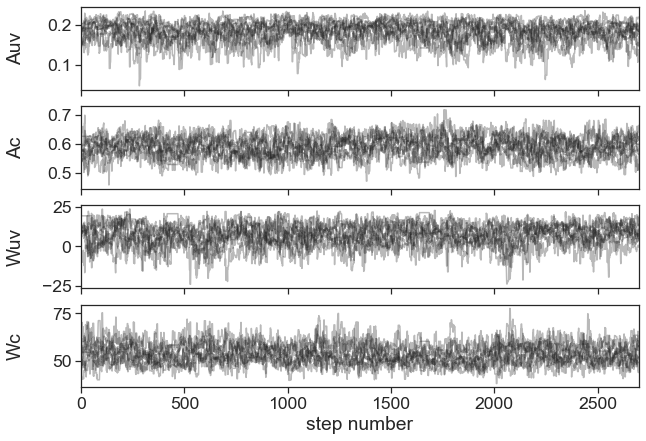

(27000, 4)


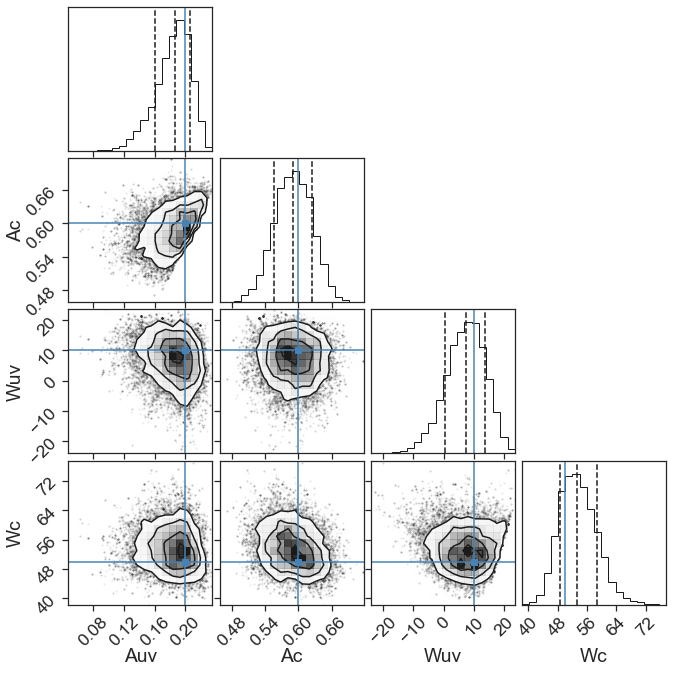

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

 19%|█▉        | 566/3000 [00:18<01:13, 33.09it/s]<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100%|██████████| 3000/3000 [01:36<00:00, 31.00it/s]


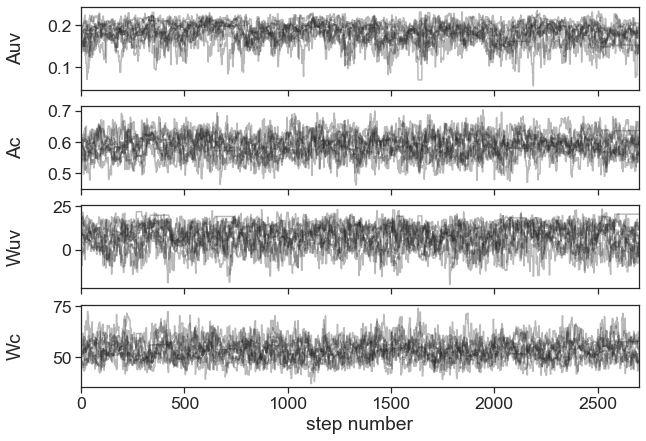

(27000, 4)


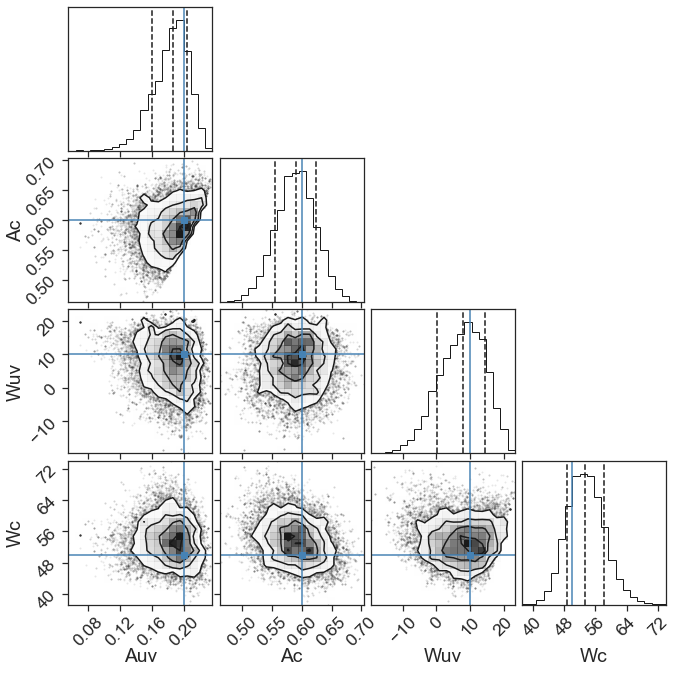

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

 33%|███▎      | 1003/3000 [00:32<01:04, 31.18it/s]<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100%|██████████| 3000/3000 [01:39<00:00, 30.23it/s]


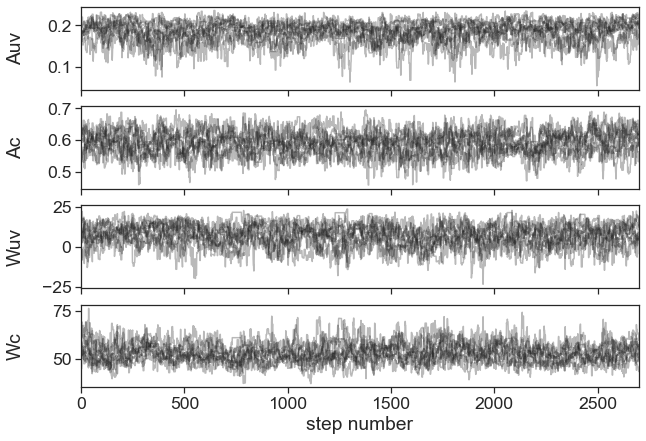

(27000, 4)


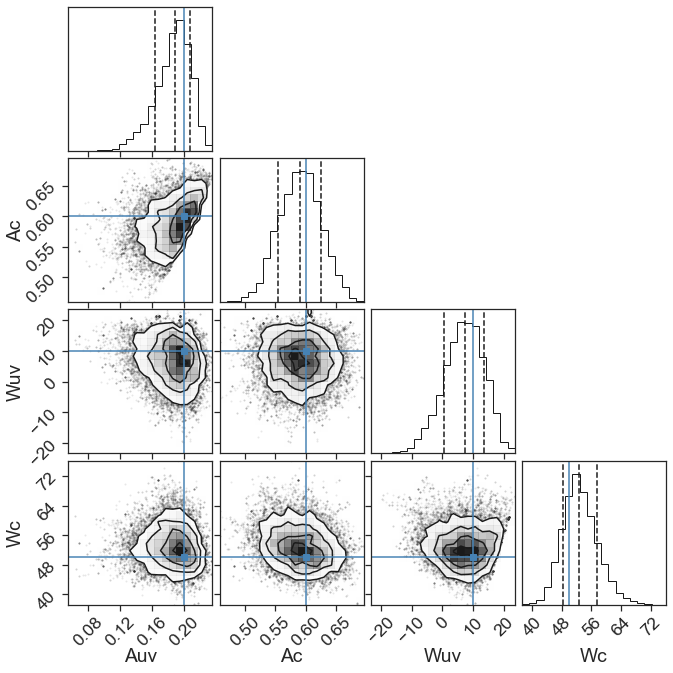

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  9%|▉         | 275/3000 [00:09<01:17, 35.05it/s]<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100%|██████████| 3000/3000 [01:33<00:00, 32.10it/s]


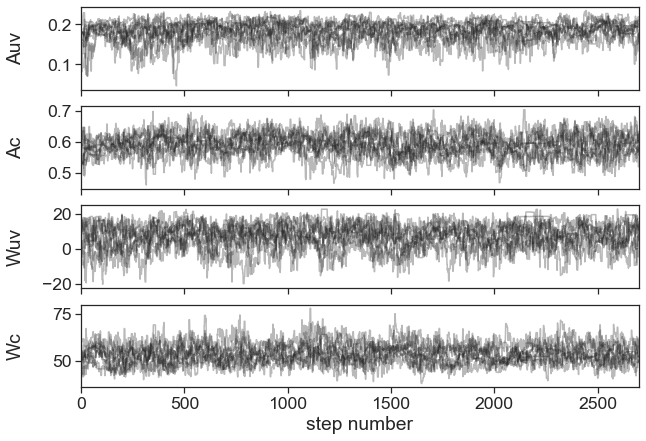

(27000, 4)


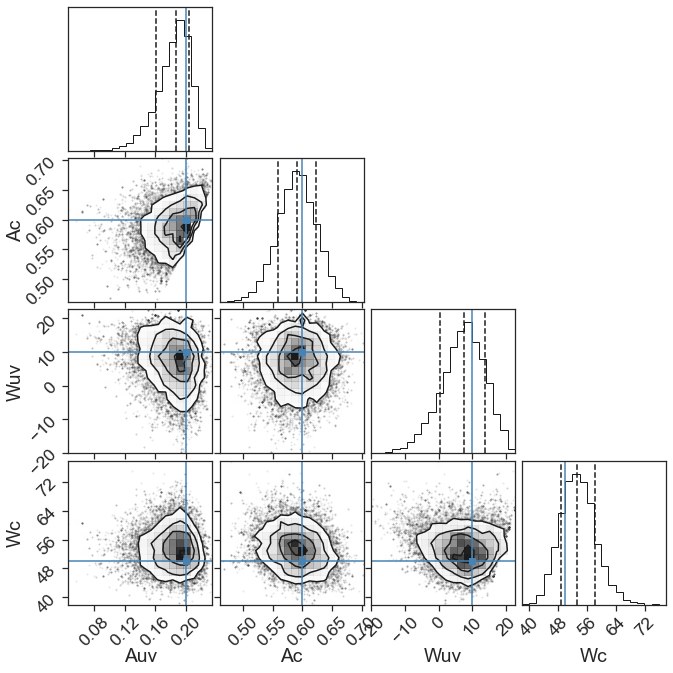

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  8%|▊         | 229/3000 [00:07<01:26, 32.07it/s]<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-31-1761ebcb8834>:16: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 76%|███████▌  | 2281/3000 [01:12<00:26, 27.46it/s]Traceback (most recent call last):
  File "/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-31-1761ebcb8834>", line 82, in log_probability
    lL=log_likelihood(theta, y, yerr,physParams=DrawnphysParams)
  File "<ipython-input-31-1761ebcb8834>", line 70, in log_likelihood
    model = Posterior(y,yerr,physParams,[Auv,Ac],[Wuv,Wc]) # Does thus have to be exp, so it gets outside the logaritm?
  File "<ipython-input-31-1761ebcb8834>", line 

emcee: Exception while calling your likelihood function:
  params: [ 0.16997224  0.53990255  6.98922123 48.61860666]
  args: ([15.677626290573212, -4.360460706372303, 14.167006053186622, 28.86581862360202, 0.5279040590146471, -4.476914727446083, 60.18201618012234, 2.1569001574929363, 20.455042204475717, -2.1676215142062265, 3.067849329064247, 23.300143104905096, 2.716526228040629, 4.039387034814327, 2.942443783101033, 39.35792844847566, -12.896896989676465, 109.80623780146571, -0.7993460615684589, 9.44009929555067, 28.87941807975735, -8.527613317767337, 3.2712156931050873, 5.268414433727439, 9.530558227203633, 0.8731608808026781, -8.243293833646282, 18.60460195620899, -3.4671747450086707, 162.9605048892337, 37.03327643637582, 6.47178893715806, 197.78001878133244, 16.772433191251476, 246.18332672003626, 54.02244069578444, -7.7874797085697995, 28.98241052083752, -2.898769675494064, -9.221049403437911, -0.7983143244658815, -1.2535773333513367, 29.040131804593013, 62.813751281959235, 2.074

KeyboardInterrupt: 

In [37]:
for iiii in range(0,10):    
    steps=3000
    nwalkers=10

    inValuesA=[0.,0.5]
    inValuesW=[0,100]

    inValues=inValuesA+inValuesW

    pos = inValues+ [0.01,0.2,1,30] * np.random.randn(nwalkers,len(inValues) )
    nwalkers, ndim = np.shape(pos)

    #mp_pool = multiproc.ProcessPool(nodes=8)
    #with mp_pool as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(EW_obs , dEW)
    )
    sampler.run_mcmc(pos, steps, progress=True)




    dis=300
    labels = ["Auv","Ac","Wuv","Wc"]
    fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=dis)
    logProb=sampler.get_log_prob(discard=dis)
    maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
    samples=np.array([s[maskWalkers] for s in samples])
    for i in range(len(labels)):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.show()



    ndim=len(labels)
    samples = sampler.get_chain(discard=dis)
    samples=np.array([s[maskWalkers] for s in samples])
    np.save("results/samples"+str(iiii)+".npy",samples)
    samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
    print(np.shape(samples))


    fig = corner.corner(
        samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
    )
    plt.show()

    results=[]
    r16,r84=[],[]
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        r16.append(mcmc[0])
        r84.append(mcmc[2])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))


    np.save("results-3/results"+str(iiii)+".npy",results)

In [ ]:

mockParamsA=[0.12,3.2]
mockParamsW=[8,230]


#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x,probSets,As,Ws=BInf.GenerateMockData(mockParamsA,mockParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.05,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)

In [ ]:
import glob
resultados=glob.glob("results/results*.npy")

results=[]
for res in resultados:
    results.append(np.load(res))

resultWs=[]
resultAs=[]
for r in results:
    Amuv,Ac=r[0],r[1]
    Wmuv,Wc=r[2],r[3]                                                                                                      
    __,__,As,Ws=BInf.GenerateMockDataConvolved([Amuv,Ac],[Wmuv,Wc])
    resultWs.append(Ws)
    resultAs.append(As)
    

In [ ]:

for rW,rA in zip(resultWs,resultAs):
    plt.errorbar(TrueWs,rW,fmt="-",alpha=0.5,color="black")
    plt.plot([40,90],[40,90],color="black",ls="--")
    plt.xlabel("True W")
    plt.ylabel("Result W")
plt.show()
for rW,rA in zip(resultWs,resultAs):
    plt.errorbar(TrueAs,rA,alpha=0.5,fmt="-",color="black")
    plt.plot([0.4,1],[0.4,1],color="black",ls="--")
    plt.xlabel("True A")
    plt.ylabel("Result A")
plt.show()



In [ ]:
import imageio
from PIL import Image

results_transposed = np.transpose(results)

x,probSets1,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
x2,probSets2,As,Ws=BInf.GenerateMockDataConvolved([np.median(results_transposed[0]),np.median(results_transposed[1])],[np.median(results_transposed[2]),np.median(results_transposed[3])])

# Create a list to store the images
images = []

# Loop through the probSets1 and probSets2
for p1, p2 in zip(probSets1, probSets2):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p1)
    ax.plot(x, p2)
    ax.set_xlim(-10, 200)
    
    # Save the figure as an image
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.close(fig)

# Save the images as a GIF
imageio.mimsave('plots_2.gif', images)